# PINN with PINA
## Load modules & Check PyTorch

In [1]:
# Import modules
import torch
# import torch.nn as nn
# import torch.optim as optim

import pandas as pd

# data processing
import random as r
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [2]:
# Debugger: Aktiviert
debug_mode = True

## Preloaded Modules

## Check for use of CONDA if available

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

No GPU available.


# Recurrent Neural Networks

Just as people do not have to think again each time about the things they have already learned, it is also possible to teach neural networks to recall knowledge they were being taught. This is done in so-called Recurrent Neural Networks (RNNs) with loops inside, which allow information to be retained. Currently the most used architectures of RNNs are Long short-term memory (LSTM) networks. LSTMs are RNNs that overcome the problem of long-term dependencies and thus have achieved the most state-of-the-art results in this area. In this exercise we will look at how to use LSTMs to predict future values using time series data sets.

## Data processing

In [4]:
import random

class Oedometer:
    def __init__(self, e_0: float = 1.00, C_c: float = 0.005, delta_epsilon: float = 0.0005, 
                 sigma_t: float = 1.00, max_n: int = 50, rand_epsilon:bool=False, **kwargs):
        self.max_n = max_n

        # Standardwerte als Listen setzen
        self.e_0 = [e_0]
        self.C_c = [C_c]
        self.sigma_t = [sigma_t]
        self.delta_epsilon = []
        self.total_epsilon = [0]

        # Initiale Listen für Berechnungen
        self.sigma_t = [sigma_t]
        self.delta_sigma = []
        self.e_s = []
        self.delta_epsilon = [delta_epsilon]
        
        # Dynamische Zuweisung von kwargs, falls vorhanden
        for key, value in kwargs.items():
            if hasattr(self, key):  # Nur vorhandene Attribute setzen
                setattr(self, key, [value])
        
        # Berechnungen durchführen
        self.__calc_sigma_t_p1()

        # Listenlängen anpassen
        self.__adjust_list_lengths()
        self.__calc_total_epsilon()

    def __adjust_list_lengths(self):
        """ Passt ALLE Listen-Attribute an `max_n` an. """
        attributes = ['e_0', 'C_c', 'delta_epsilon', 'sigma_t', 'sigma_t', 'delta_sigma', 'e_s']
        for attr in attributes:
            value_list = getattr(self, attr, [])
            current_length = len(value_list)

            if current_length > self.max_n:
                setattr(self, attr, value_list[:self.max_n])  # Kürzen
            elif current_length < self.max_n:
                setattr(self, attr, value_list + [value_list[-1] if value_list else 0] * (self.max_n - current_length))  # Auffüllen
    
    def __calc_total_epsilon(self):
        for i in range(len(self.delta_epsilon)-1):
            self.total_epsilon.append(self.total_epsilon[i] + self.delta_epsilon[i])            
    
    def __calc_e_s(self, sigma_t):
        """ Berechnet `e_s` aus `sigma_t`. """
        e_s = (1 + self.e_0[0]) / self.C_c[0] * sigma_t
        self.e_s.append(e_s)
        return e_s

    def __calc_sigma_t_p1(self):
        """ Berechnet `sigma_t` und `delta_sigma` für die nächsten Schritte. """
        for i in range(self.max_n):  # -1, weil sigma_t bereits gesetzt ist
            e_s = self.__calc_e_s(self.sigma_t[i])
            delta_sigma = e_s * self.delta_epsilon[0]
            sigma = self.sigma_t[i] + delta_sigma
            self.sigma_t.append(sigma)
            self.delta_sigma.append(delta_sigma)

def plot_input():
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(data_dict_raw['sigma_t'], data_dict_raw['delta_sigma'], marker='o', linestyle='-', label='Sigma_0 = 1')
    
    # Formatting
    plt.xlabel('sigma_t')
    plt.ylabel('delta_simga')
    plt.title('Sigma_0 in relation to Sigma_1')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
i = 1

oedo_para = {
    'max_n': 100, 
    'e_0': 1.0, 
    'C_c': 0.005,   
    'total_epsilon': 0,
    'e_s': 400.0
}

# Vorbereitung Tensoren
sigma_t = np.random.choice(range(1, 10000), size=i, replace=False)
delta_sigma = []
delta_epsilon = np.repeat(np.array(np.float64(0.0005)), oedo_para['max_n'])
# delta_epsilon = np.random.uniform(0.0001, 0.001, size=i)

oedo = Oedometer(**oedo_para)
delta_sigma
delta_sigma = list(oedo.delta_sigma)
sigma_t = list(oedo.sigma_t)

    
print('Anzahl Elemente delta_epsilon: ' + str(len(delta_epsilon)))
print('Anzahl Elemente sigma_t: ' + str(len(sigma_t)))
print('Anzahl Elemente delta_sigma: ' + str(len(delta_sigma)))

Anzahl Elemente delta_epsilon: 100
Anzahl Elemente sigma_t: 100
Anzahl Elemente delta_sigma: 100


In [6]:
data = [['sigma_t'] + sigma_t, ['delta_sigma'] + delta_sigma, ['delta_epsilon'] + delta_epsilon.tolist()]
import tabulate
table = tabulate.tabulate(data, tablefmt='html')
table

sigma_t,1,1.2,1.44,1.728,2.0736,2.48832,2.98598,3.58318,4.29982,5.15978,6.19174,7.43008,8.9161,10.6993,12.8392,15.407,18.4884,22.1861,26.6233,31.948,38.3376,46.0051,55.2061,66.2474,79.4968,95.3962,114.475,137.371,164.845,197.814,237.376,284.852,341.822,410.186,492.224,590.668,708.802,850.562,1020.67,1224.81,1469.77,1763.73,2116.47,2539.77,3047.72,3657.26,4388.71,5266.46,6319.75,7583.7,9100.44,10920.5,13104.6,15725.6,18870.7,22644.8,27173.8,32608.5,39130.2,46956.3,56347.5,67617,81140.4,97368.5,116842,140211,168253,201903,242284,290741,348889,418667,502400,602880,723456,868147,1.04178e+06,1.25013e+06,1.50016e+06,1.80019e+06,2.16023e+06,2.59227e+06,3.11073e+06,3.73287e+06,4.47945e+06,5.37534e+06,6.45041e+06,7.74049e+06,9.28859e+06,1.11463e+07,1.33756e+07,1.60507e+07,1.92608e+07,2.3113e+07,2.77356e+07,3.32827e+07,3.99392e+07,4.79271e+07,5.75125e+07,6.9015e+07
delta_sigma,0.2,0.24,0.288,0.3456,0.41472,0.497664,0.597197,0.716636,0.859963,1.03196,1.23835,1.48602,1.78322,2.13986,2.56784,3.0814,3.69769,4.43722,5.32467,6.3896,7.66752,9.20102,11.0412,13.2495,15.8994,19.0792,22.8951,27.4741,32.9689,39.5627,47.4753,56.9703,68.3644,82.0373,98.4447,118.134,141.76,170.112,204.135,244.962,293.954,352.745,423.294,507.953,609.544,731.452,877.743,1053.29,1263.95,1516.74,1820.09,2184.11,2620.93,3145.11,3774.13,4528.96,5434.75,6521.7,7826.04,9391.25,11269.5,13523.4,16228.1,19473.7,23368.4,28042.1,33650.6,40380.7,48456.8,58148.2,69777.8,83733.3,100480,120576,144691,173629,208355,250026,300032,360038,432046,518455,622146,746575,895890,1.07507e+06,1.29008e+06,1.5481e+06,1.85772e+06,2.22926e+06,2.67511e+06,3.21014e+06,3.85216e+06,4.6226e+06,5.54711e+06,6.65654e+06,7.98784e+06,9.58541e+06,1.15025e+07,1.3803e+07
delta_epsilon,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005


In [7]:
from sklearn.preprocessing import MinMaxScaler

data = {
    'input1': sigma_t,
    'input2': delta_epsilon,
    'output': delta_sigma
}
df = pd.DataFrame(data)

# Normalisierung
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Zurück in DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
df_scaled

,input1,input2,output
0,0.000000e+00,0.0,0.000000e+00
1,2.897922e-09,0.0,2.897922e-09
2,6.375428e-09,0.0,6.375428e-09
3,1.054843e-08,0.0,1.054843e-08
4,1.555604e-08,0.0,1.555604e-08
...,...,...,...
95,4.822531e-01,0.0,4.822531e-01
96,5.787037e-01,0.0,5.787037e-01
97,6.944444e-01,0.0,6.944444e-01
98,8.333333e-01,0.0,8.333333e-01


## Auszug aus Tutorial 6

    # Create sequences
    # Function to create sequences of input (passenger of train_window months) and ...
    # ... output passenger of train_window+1 month
    
    def create_inout_sequences(input_data, tw):
        inout_seq = []
        L = len(input_data)
        for i in range(L-tw):
            train_seq = input_data[i:i+tw]
            train_label = input_data[i+tw:i+tw+1]
            inout_seq.append((train_seq ,train_<label))
        return inout_seq
    
    # Set an appropiate Train window
    # TODO start**
    train_window = 24
    
    # Create sequences 
    trva_inout_seq = create_inout_sequences(trva_data_normalized, train_window)
    
    # Print the first 3 sequences
    print(trva_inout_seq[:3])

In [8]:
import numpy as np
import torch

lookback=1

def create_dataset(df, lookback=1):
    """
    Erzeugt die Eingabe- und Ziel-Datensätze für ein LSTM.
    
    lookback definiert hier, wie viele vergangene Zeitschritte
    (Train Window / Sequences im Tutorial) das Modell als Input
    für jede Vorhersage erhält. Dadurch entsteht die nötige
    3D-Form (batch_size, seq_length, input_size), die ein LSTM erwartet,
    um zeitliche Abhängigkeiten zu lernen.
    """
    X, y = [], []
    for i in range(len(df) - lookback):
        # Wir nehmen hier 'lookback' Zeilen als eine Sequenz,
        # damit das LSTM-Modell weiß, wie weit es in die Vergangenheit
        # zurückschauen muss. Ohne diese Sequenz-Dimension (seq_length)
        # wäre die Eingabe nur eine 2D-Matrix und das LSTM könnte
        # keine zeitlichen Muster erfassen.
        seq = df.iloc[i:i+lookback, :-1].values
        X.append(seq)
        
        # Zielwert: der Wert direkt nach dieser Sequenz
        y.append(df.iloc[i+lookback, -1])
    
    # Rückgabe als Tensor mit Form (batch_size, seq_length, input_size) und (batch_size,)
    return torch.tensor(np.array(X), dtype=torch.float32), \
           torch.tensor(np.array(y), dtype=torch.float32)

X, y = create_dataset(df_scaled, lookback)
X_input_all = df_scaled.iloc[lookback:, :-1].to_numpy(dtype=np.float32)

# Falls lookback=1, wäre X anfangs (5000, 1, 2).
# Mit squeeze() könnte man die mittlere Dimension entfernen,
# aber für LSTM brauchen wir sie genau so:
X = X.squeeze()
print(np.shape(X))

torch.Size([99, 2])


In [9]:
# --- Aufteilen in Training (2/3) und Test (1/3) ---
train_size = int(X.shape[0] * 2/3)
X_train = X[:train_size]
y_train = y[:train_size].view(-1, 1)  # als (batch_size, 1)
X_test  = X[train_size:]
y_test  = y[train_size:].view(-1, 1)

X_input_train = X_input_all[:train_size]
X_input_test  = X_input_all[train_size:]

print("Shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape, "X_input_train:", X_input_train.shape)
print("  X_test: ", X_test.shape,  "y_test: ", y_test.shape,  "X_input_test: ",  X_input_test.shape)

Shapes:
  X_train: torch.Size([66, 2]) y_train: torch.Size([66, 1]) X_input_train: (66, 2)
  X_test:  torch.Size([33, 2]) y_test:  torch.Size([33, 1]) X_input_test:  (33, 2)


In [10]:
# PINA NN Model
from pina.problem import AbstractProblem
from pina.geometry import CartesianDomain
from pina import Condition
from pina.utils import LabelTensor

input_points_combined = LabelTensor(X_train, ['sigma_t', 'delta_epsilon'])
delta_sigma_train = LabelTensor(y_train, ['delta_sigma'])
input_conditions = {'data': Condition(input=input_points_combined, target=delta_sigma_train),}


class SimpleODE(AbstractProblem):

    # Definition der Eingabe- und Ausgabevariablen basierend auf LabelTensor
    input_variables = input_points_combined.labels
    output_variables = delta_sigma_train.labels

    # Wertebereich
    domain = CartesianDomain({'sigma_t': [0, 1], 'delta_epsilon': [0, 1]})  # Wertebereich immer definieren!

    # Definition der Randbedingungen und (hier: nur) vorberechnetet Punkte
    conditions = input_conditions

    output_pts=delta_sigma_train

    # Methode zur Definition der "wahren Lösung" des Problems
    def truth_solution(self, pts):
        return torch.exp(pts.extract(['sigma_t']))

# Problem-Instanz erzeugen
problem = SimpleODE()



if debug_mode:
    # Debugging-Ausgaben
    print("‼️Geladene Input Variablen: ", problem.input_variables)
    print("‼️Geladene Output Variablen: ", problem.output_variables)
    print('‼️Input points:', problem.input_pts)

‼️Geladene Input Variablen:  ['sigma_t', 'delta_epsilon']
‼️Geladene Output Variablen:  ['delta_sigma']
‼️Input points: {'data': LabelTensor([[0.0000e+00, 0.0000e+00],
             [2.8979e-09, 0.0000e+00],
             [6.3754e-09, 0.0000e+00],
             [1.0548e-08, 0.0000e+00],
             [1.5556e-08, 0.0000e+00],
             [2.1565e-08, 0.0000e+00],
             [2.8776e-08, 0.0000e+00],
             [3.7429e-08, 0.0000e+00],
             [4.7813e-08, 0.0000e+00],
             [6.0274e-08, 0.0000e+00],
             [7.5226e-08, 0.0000e+00],
             [9.3169e-08, 0.0000e+00],
             [1.1470e-07, 0.0000e+00],
             [1.4054e-07, 0.0000e+00],
             [1.7155e-07, 0.0000e+00],
             [2.0875e-07, 0.0000e+00],
             [2.5340e-07, 0.0000e+00],
             [3.0698e-07, 0.0000e+00],
             [3.7127e-07, 0.0000e+00],
             [4.4842e-07, 0.0000e+00],
             [5.4101e-07, 0.0000e+00],
             [6.5211e-07, 0.0000e+00],
             

C:\Users\lukas\Documents\git_projects\pina_oedometer\venv\Lib\site-packages\pina\geometry\__init__.py: DeprecationWarning: 'pina.geometry' is deprecated and will be removed in future versions. Please use 'pina.domain' instead. Location moved to DomainInferface object.


In [11]:
from pina import Trainer
from pina.solver import PINN
from pina.model import FeedForward
from pina.callback import MetricTracker
import torch
from pytorch_lightning.loggers import TensorBoardLogger  # Import TensorBoard Logger

if debug_mode:
    print('Debugging Info:')
    # Überprüfen der Größe der Eingabepunkte und Ausgabepunkte
    print("‼️Länge der Eingabepunkte (input_pts):", len(problem.input_pts))
    print("‼️Länge der Ausgabepunkte (output_pts):", len(problem.output_pts))

# Model erstellen
model = FeedForward(
    layers=[50, 50, 50],
    func=torch.nn.ReLU,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

# PINN-Objekt erstellen
pinn = PINN(problem, model)


# Trainer erstellen mit TensorBoard-Logger
trainer = Trainer(
    solver=pinn,
    max_epochs=100,
    callbacks=[MetricTracker()],
    batch_size=10,
    accelerator='cpu',
    enable_model_summary=False,
)


# Training starten
trainer.train()

print('\nFinale Loss Werte')

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Debugging Info:
‼️Länge der Eingabepunkte (input_pts): 1
‼️Länge der Ausgabepunkte (output_pts): 66


C:\Users\lukas\Documents\git_projects\pina_oedometer\venv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
C:\Users\lukas\Documents\git_projects\pina_oedometer\venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|█| 7/7 [00:00<00:00, 35.45it/s, v_num=49, data_loss_step=4.22e-8, train_loss_step=4.22e-8, data_loss_epo

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|█| 7/7 [00:00<00:00, 30.66it/s, v_num=49, data_loss_step=4.22e-8, train_loss_step=4.22e-8, data_loss_epo

Finale Loss Werte


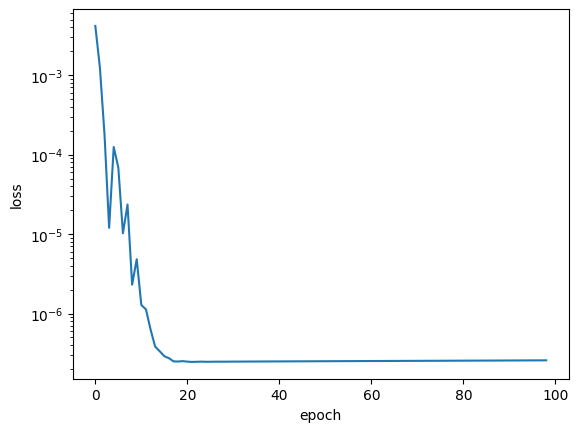

In [12]:
# plot loss
trainer_metrics = trainer.callbacks[0].metrics
loss = trainer_metrics["train_loss_epoch"]
epochs = range(len(loss))
plt.plot(epochs, loss.cpu())
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")

In [13]:
from IPython.display import display, Markdown
def plot_prediction_vs_true_solution(pinn, data_dict, graph_folder, img_visual_prediction_vs_truesolution, 
                                     img_extensions, y_axis='delta_sigma', max_i=20, plot_type="line"):
    """
    Erstellt und speichert eine Vorhersage- vs. True-Solution-Grafik für ein gegebenes PINN-Modell.

    :param pinn: Das trainierte PINN-Modell zur Vorhersage von delta_sigma
    :param data_dict: Dictionary mit den Eingabe- und wahren Ausgabe-Daten
    :param graph_folder: Ordner, in dem das Bild gespeichert wird
    :param img_visual_prediction_vs_truesolution: Dateiname der gespeicherten Grafik (ohne Erweiterung)
    :param img_extensions: Dateiformat der gespeicherten Grafik (z.B. '.png' oder '.jpg')
    :param max_i: Anzahl der Datenpunkte, die im Plot gezeigt werden sollen (Default: 20)
    :param delta_epsilon: Wert für delta_epsilon, um ihn im Titel anzuzeigen (optional)
    :param plot_type: Art der Darstellung - "line" für Linienplot, "scatter" für Punktplot (Default: "line")
    """

    # Überprüfen, ob die notwendigen Keys vorhanden sind
    if "sigma_t" not in data_dict or y_axis not in data_dict:
        print(f"Fehler: sigma_t oder y_axis fehlen im data_dict!")
        return

    # Eingabedaten für das Modell vorbereiten
    input_data = LabelTensor(torch.tensor(
        np.column_stack((data_dict['sigma_t'], data_dict['delta_epsilon'])), 
        dtype=torch.float), ['sigma_t', 'delta_epsilon'])

    # Vorhersage berechnen
    sigma_t_pred = pinn(input_data).detach().numpy()

    # Plot erstellen
    plt.figure(figsize=(10, 5))

    y_vals = data_dict[y_axis][0:max_i]
    x_true = data_dict['delta_sigma'][0:max_i]
    x_pred = sigma_t_pred[0:max_i]

    if plot_type == "line":
        plt.plot(x_true, y_vals, label="True Solution (delta_sigma)", linestyle='dashed', color='blue')
        plt.plot(x_pred, y_vals, label="NN Prediction (delta_sigma)", linestyle='solid', color='red')
    elif plot_type == "scatter":
        plt.scatter(x_true, y_vals, label="True Solution (delta_sigma)", color='blue', marker='o')
        plt.scatter(x_pred, y_vals, label="NN Prediction (delta_sigma)", color='red', marker='x')

    plt.xlabel("delta_sigma")
    plt.ylabel(y_axis)
    plt.title(f"Prediction vs. True Solution (max_i={max_i-1})")
    plt.legend()
    plt.grid()
    plt.gca().invert_yaxis()
    
    # Bild speichern
    img_path = f'./{graph_folder}/{img_visual_prediction_vs_truesolution}{img_extensions}'
    plt.savefig(img_path)
    plt.close()  # Verhindert doppelte Darstellung

    # Markdown-Ausgabe in Jupyter Notebook
    display(Markdown(f'![Prediction vs True Solution]({img_path})<br>**Hinweis:** Datenpunkte liegen sehr nahe beieinander.'))

def display_data_loss_table(data_dict, delta_sigma_pred, max_i):
    """
    Erstellt eine Markdown-Tabelle zur übersichtlichen Darstellung von Datenverlust.
    
    Unterstützt sowohl Python-Listen als auch NumPy-Arrays.
    
    :param data_dict: Dictionary mit `sigma_t` und `delta_sigma` (Listen oder np.arrays)
    :param delta_sigma_pred: Vorhergesagte Werte für `delta_sigma` (Liste oder np.array)
    :param max_i: Anzahl der Werte, die in der Tabelle angezeigt werden sollen
    """
    
    # Sicherstellen, dass `sigma_t` und `delta_sigma` existieren
    if "sigma_t" not in data_dict or "delta_sigma" not in data_dict or delta_sigma_pred is None:
        print("Fehler: `data_dict` oder `delta_sigma_pred` ist nicht korrekt definiert!")
        return

    # Konvertiere alle Werte zu Listen (falls sie NumPy-Arrays sind)
    def to_list(arr):
        return arr.tolist() if isinstance(arr, np.ndarray) else arr

    delta_epsilon = to_list(data_dict["delta_epsilon"])
    sigma_t = to_list(data_dict["sigma_t"])
    delta_sigma_true = to_list(data_dict["delta_sigma"])
    delta_sigma_pred = to_list(delta_sigma_pred.flatten())  # Falls `delta_sigma_pred` ein 2D-Array ist
    
    # Überprüfen, ob die Längen konsistent sind
    min_len = min(len(sigma_t), len(delta_epsilon), len(delta_sigma_true), len(delta_sigma_pred), max_i)

    # Erstelle eine Tabelle für die übersichtliche Darstellung
    data_loss_table = {
        "delta_epsilon" : list(delta_epsilon[:min_len]), 
        "sigma_t" : list(sigma_t[:min_len]), 
        "True delta_sigma": list(delta_sigma_true[:min_len]),
        "Predicted delta_sigma": list(delta_sigma_pred[:min_len]),
        "Test-Loss (True - Predicted)": list(np.round(np.array(delta_sigma_true[:min_len]) - np.array(delta_sigma_pred[:min_len]), 5))
    }

    # Markdown-Tabelle für bessere Darstellung in Jupyter
    display(dict_to_markdown_table(data_loss_table, title=f"Data-Loss bis sigma_{min_len-1}", include_index=True))

def dict_to_markdown_table(data: dict, title: str = "Datenübersicht", include_index: bool = True, round_digits: int = 4):
    """
    Wandelt ein Dictionary mit Listenwerten in eine Markdown-Tabelle für Jupyter Notebooks um.
    
    - Schlüssel werden als Header genutzt
    - Erste Spalte ist ein Index, falls `include_index=True`
    - Einzelwerte werden als separate Tabelle unterhalb dargestellt
    - Zahlenwerte werden auf eine einstellbare Anzahl an Nachkommastellen gerundet

    :param data: Dictionary mit Key-Value-Paaren
    :param title: Überschrift für die Tabelle
    :param include_index: Falls True, wird eine Index-Spalte erstellt
    :param round_digits: Anzahl der Nachkommastellen, auf die Werte gerundet werden sollen
    :return: Markdown-String zur Anzeige in Jupyter
    """
    
    # Hilfsfunktion zum Runden von Zahlen
    def round_value(val):
        if isinstance(val, (int, float)):
            return round(val, round_digits)
        return val

    # Listen und einzelne Werte trennen
    list_data = {k: v for k, v in data.items() if isinstance(v, list)}
    single_values = {k: v for k, v in data.items() if not isinstance(v, list)}

    # Falls es Listen gibt, erstelle eine Tabelle mit Index
    if list_data:
        max_len = max(len(v) for v in list_data.values())  # Längste Liste bestimmen

        # Tabellenkopf
        md_table = f"### {title}\n\n"
        md_table += "| " + ("Index | " if include_index else "") + " | ".join(list_data.keys()) + " |\n"
        md_table += "|-" + ("-|" if include_index else "") + "-|".join(["-" * len(k) for k in list_data.keys()]) + "-|\n"

        # Datenzeilen
        for i in range(max_len):
            row = [str(i)] if include_index else []  # Index hinzufügen (optional)
            for key in list_data:
                if i < len(list_data[key]):
                    row.append(str(round_value(list_data[key][i])))
                else:
                    row.append("")  # Leere Werte für ungleich lange Listen
            md_table += "| " + " | ".join(row) + " |\n"
    
    else:
        md_table = ""

    # Einzelwerte als extra Tabelle darstellen
    if single_values:
        md_table += "\n\n#### Einzelwerte\n\n"
        md_table += "| " + " | ".join(single_values.keys()) + " |\n"
        md_table += "|-" + "-|".join(["-" * len(k) for k in single_values.keys()]) + "-|\n"
        md_table += "| " + " | ".join(map(lambda v: str(round_value(v)), single_values.values())) + " |\n"

    return Markdown(md_table)

In [14]:
data['sigma_t'] = data.pop('input1')
data['delta_epsilon'] = data.pop('input2')
data['delta_sigma'] = data.pop('output')

In [15]:
def denormalize_delta_sigma(delta_sigma_pred, scaler):
    """
    Denormalisiert die Vorhersagewerte für delta_sigma zurück auf den ursprünglichen Bereich.
    
    :param delta_sigma_pred: Normalisierte Vorhersagewerte für `delta_sigma`
    :param scaler: Der MinMaxScaler, der für die Normalisierung verwendet wurde
    :return: Denormalisierte Werte für `delta_sigma_pred`
    """
    # Denormalisieren basierend auf den min und max Werten des Scalers
    delta_sigma_pred_denorm = delta_sigma_pred * (scaler.data_max_[2] - scaler.data_min_[2]) + scaler.data_min_[2]
    return delta_sigma_pred_denorm


In [16]:
graph_folder = 'graph'
img_extensions = '.png'

img_visual_prediction_vs_truesolution_comp0 = 'visual_prediction-vs-truesolution_comp0'
# print(data)

# Erstelle die Eingabedaten als LabelTensor für das trainierte Modell
input_data = LabelTensor(X_test, ['sigma_t', 'delta_epsilon'])

delta_sigma_pred = denormalize_delta_sigma(pinn(input_data).detach().numpy(), scaler)

display_data_loss_table(data_dict=data, delta_sigma_pred=delta_sigma_pred, max_i=20)
plot_prediction_vs_true_solution(pinn=pinn, data_dict=data, graph_folder=graph_folder, img_visual_prediction_vs_truesolution=img_visual_prediction_vs_truesolution_comp0, 
                                     img_extensions=img_extensions, y_axis='delta_epsilon', max_i=20, plot_type="scatter")

### Data-Loss bis sigma_19

| Index | delta_epsilon | sigma_t | True delta_sigma | Predicted delta_sigma | Test-Loss (True - Predicted) |
|--|--------------|--------|-----------------|----------------------|-----------------------------|
| 0 | 0.0005 | 1.0 | 0.2 | 4088.7202 | -4088.5202 |
| 1 | 0.0005 | 1.2 | 0.24 | 4219.3274 | -4219.0874 |
| 2 | 0.0005 | 1.44 | 0.288 | 4376.3646 | -4376.0766 |
| 3 | 0.0005 | 1.728 | 0.3456 | 4564.151 | -4563.8054 |
| 4 | 0.0005 | 2.0736 | 0.4147 | 4789.9884 | -4789.5737 |
| 5 | 0.0005 | 2.4883 | 0.4977 | 5060.9727 | -5060.475 |
| 6 | 0.0005 | 2.986 | 0.5972 | 5386.051 | -5385.4538 |
| 7 | 0.0005 | 3.5832 | 0.7166 | 5776.2272 | -5775.5106 |
| 8 | 0.0005 | 4.2998 | 0.86 | 6244.3564 | -6243.4964 |
| 9 | 0.0005 | 5.1598 | 1.032 | 6806.1731 | -6805.1411 |
| 10 | 0.0005 | 6.1917 | 1.2383 | 7480.1886 | -7478.9503 |
| 11 | 0.0005 | 7.4301 | 1.486 | 8289.2335 | -8287.7475 |
| 12 | 0.0005 | 8.9161 | 1.7832 | 9260.0462 | -9258.263 |
| 13 | 0.0005 | 10.6993 | 2.1399 | 10424.9187 | -10422.7788 |
| 14 | 0.0005 | 12.8392 | 2.5678 | 11822.8273 | -11820.2594 |
| 15 | 0.0005 | 15.407 | 3.0814 | 13500.3588 | -13497.2774 |
| 16 | 0.0005 | 18.4884 | 3.6977 | 15513.3554 | -15509.6577 |
| 17 | 0.0005 | 22.1861 | 4.4372 | 17823.1492 | -17818.712 |
| 18 | 0.0005 | 26.6233 | 5.3247 | 20552.5316 | -20547.2069 |
| 19 | 0.0005 | 31.948 | 6.3896 | 24170.2488 | -24163.8592 |


![Prediction vs True Solution](./graph/visual_prediction-vs-truesolution_comp0.png)<br>**Hinweis:** Datenpunkte liegen sehr nahe beieinander.